# Data eurostatu
- Časová řada má kvartální frekvenci
- Časovou řadu si zobrazujeme pomocí pandas, ve kterém si připravíme dataset a následně ho vykreslíme pomocí matplotlib.pyplot, což je knihovna pro tvorbu grafů

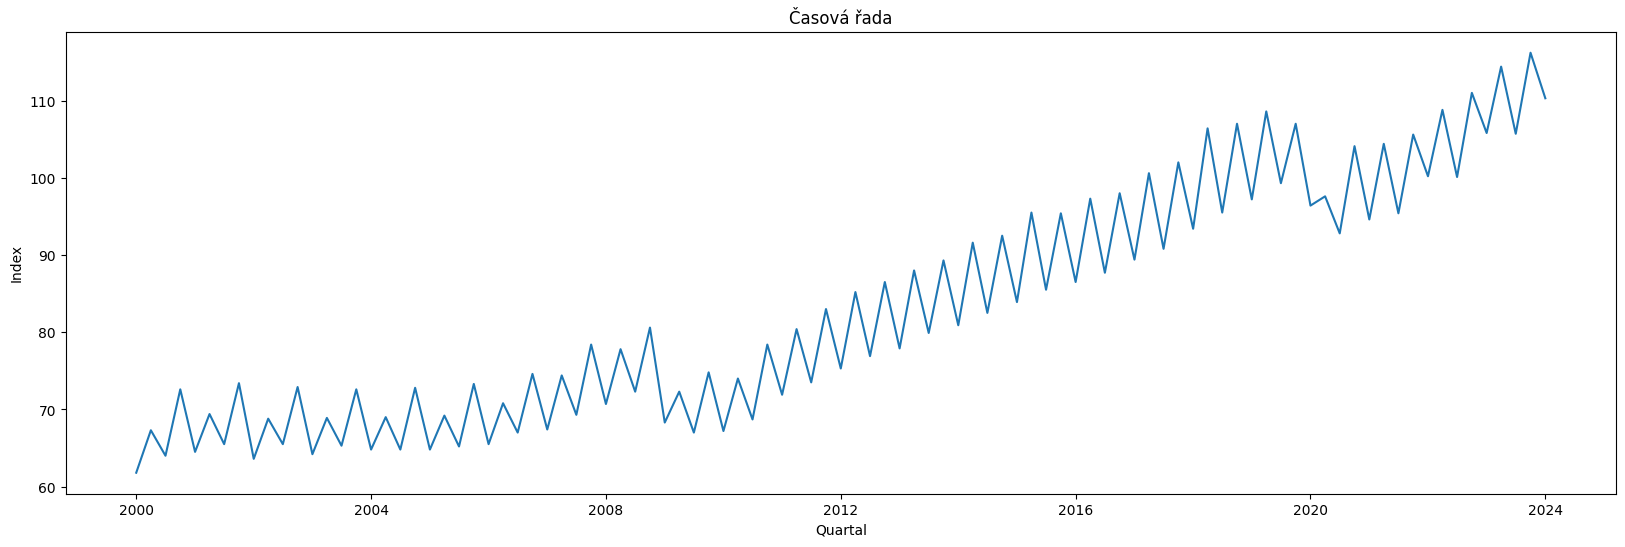

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Načtení dat z CSV souboru
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']



plt.figure(figsize=(20, 6))
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.title("Časová řada")
plt.plot(x,y)



##### Po zobrazení časové řady si můžeme všimnout, že v různých obdobích se chování liší:
- První čeho si všímám - každá změna je jeden kvartál
    - Každý sudý vrchol je narůst a každý lichý je pokles, tedy data vypadají, že budou mít sezónní složku
- 2000-2004 -> Zde vidíme už okem, že se hodnoty přiliš nemění
- 2004-2008 -> Zde hodnoty začínají lehce stoupat
- 2008-2010 -> Zde došlu k většímu poklesu, než je obvyklé v předchozích obdobích
- 2010-2020 -> Zde až k roku 2020 hodnoty stále stoupají v podobném stylu
- 2020-konec -> Dochází k "výraznějšímu" poklesu a následně zase hodnoty stoupají

# Dekompozice časové řady
- Dekompozice slouží k analýze časové řady
- Dekompozice je rozdělení časové řady na 4 složky
- Existují dva základní modely dekompozice
    - Aditivní -> 
        - Aditivní model je lineární a mění se konzistentně
    - Multiplikativní -> 
        - Multiplikativní model není lineární
- Časovou řadu rozkládáme na 3 nebo 4 složky:
    - Trendová složka
    - Cyklická složka (často zakomponuje do trendové složky)
    - Sezónní složka
    - Náhodná složka
- Dekompozice časové řady nám může pomoci k lepšímu pochopení časové řady
- Může nám pomoci při predikcích hodnot

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Převedení sloupce s časem na DATETIME
filtered_data['TIME_PERIOD'] = pd.to_datetime(filtered_data['TIME_PERIOD'])

# Nastavení sloupce s časem jako index
filtered_data.set_index('TIME_PERIOD', inplace=True)

# Ujistěte se, že data jsou seřazena podle času
filtered_data = filtered_data.sort_index()

# Výběr sloupce s hodnotami
data_values = filtered_data['OBS_VALUE']
# seasonal_decompose je funkce pro automatickou dekompozici časové řady,
# má dva modely - additive/multiplicative
dekompozice = seasonal_decompose(data_values, model="additive")

- Zde jsme si připravili data k provedení dekompozice

# Vizualizace dekompozice časové řady a residuí

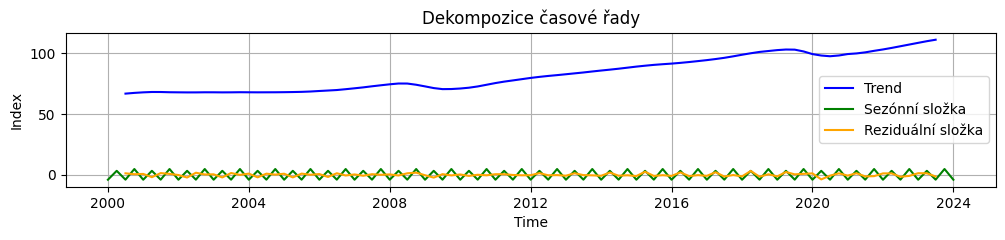

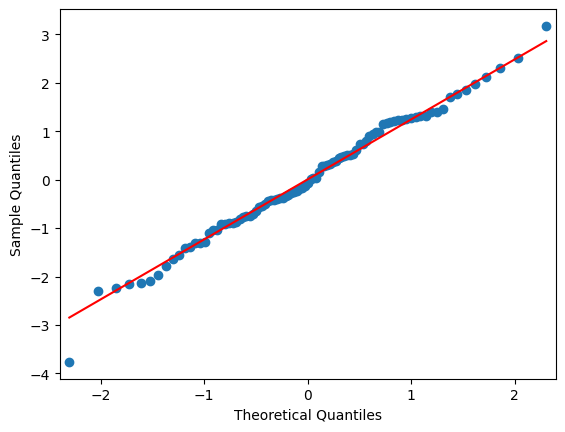

In [3]:
# Dekompozice
import statsmodels.api as sm

plt.figure(figsize=(12, 2))
plt.plot(dekompozice.trend, label='Trend', color='blue')
plt.plot(dekompozice.seasonal, label='Sezónní složka', color='green')
plt.plot(dekompozice.resid, label='Reziduální složka', color='orange')
plt.title('Dekompozice časové řady')
plt.ylabel('Index')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

# Residua
residuals = dekompozice.resid.dropna()

sm.qqplot(residuals, line='s')
plt.show()

- Po dekompozici a vizualizaci vidíme:
    - Data mají 3 složky:
        1) Složka trendová - Trend se zdá být až na občasné výkyvy rostoucí
        2) Složka sezónní - Data mají sezónní složku, která bude hrát v další analýze roli
        3) Reziduální složka - Náhodné výkyvy v datech
    - Residua
        - Residua se zdají být normálně rozložena až na pár outlierů

# Co jsou to Rezidua?
- Residua jsou náhodné variace nebo výkyvy, které zůstanou po odebrání trendu a sezónní složky
- Po odhalení residuí je lehčí porozumět chování a trendům časové řady
- Také pomáhá pro lepší predikci hodnot
- Vlastnosti:
    - Střední hodnota by měla být blízká nule, pokud je průměr daleko od nuly, může to naznačovat, že model špatně zachytil trend nebo sezónní složky
    - Rozptyl by měl být konstantní (homoskedasticita), pokud se rozptyl mění, nazýváme to heteroskedasticita, což může znamenat, že model nezachytil všechny důležité vzory
    - Normalita Rezidua by měla být přivližně normálně rozložena, pokud rezidua neodpovídají normálnímu rozdělení, může znamenat, že model není optimální nebo že jsou přitomny nějaké nelineární vztahy
- Jak s nimi pracovat?
    - Vizuální analýza -> Graf reziduí, QQ plot
    - Statistické testy:
        - Testy normality
        - Testy homoskedasticity

# Lineární regrese
- Lineární regrese je přímka, která hledá vztah mezi proměnnými
- Používá se pro predikci budoucích hodnot
- Yt = B0 + B1 * t
- Používáme funkce LinearRegression z balíčku sklearn.linear_model, pomocí kterého si vytvoříme model, který následně fitujeme a potom pomocí něho predikujeme hodnoty


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Filtrace dat
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

# Převedení TIME_PERIOD na datetime a následně na číselné hodnoty (např. pořadové číslo dne)
filtered_data['TIME_PERIOD'] = pd.to_datetime(filtered_data['TIME_PERIOD'])
x = np.array(filtered_data['TIME_PERIOD'].map(pd.Timestamp.toordinal)).reshape((-1, 1))

# Vytvoření y jako OBS_VALUE
y = np.array(filtered_data['OBS_VALUE'])

# Lineární regrese
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
print(f"Determinační koeficient: {r2}")

y_pred = model.predict(x)

Determinační koeficient: 0.86012369474415


- Zde si:
    1) Připravíme data německé časové řady
    2) Vytvoříme model Lineární regrese, kterým se snažíme popsat časovou řadu
    3) Vypočítáme determinační koeficient, který nám udává jak moc tento model vystihuje časovou řadu
- Koeficient nám vyšel 0.86, což budu brát jako věrohodný model

# Vizualizace predikce pomocí Lineární regrese

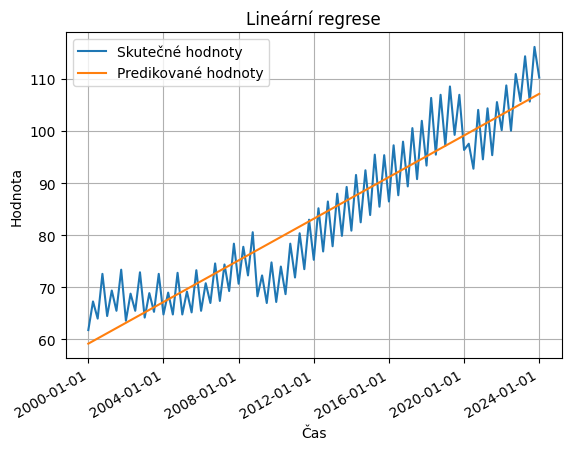

In [5]:
# Vytvoření grafu
plt.plot(filtered_data['TIME_PERIOD'], y, label='Skutečné hodnoty')
plt.plot(filtered_data['TIME_PERIOD'], y_pred, label='Predikované hodnoty')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.title('Lineární regrese')

# Nastavení formátu data na ose x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Automatické otáčení popisů na ose x

plt.legend()
plt.grid(True)
plt.show()

- Zde si proložíme přímku lineární regrese skrz naší časovou řadu
    - Je vidět, že v některých bodech přímka popisuje špatně (body, ve kterých dochází k výkyvům a začátek časové řady)
    - Možná by bylo vhodné proložit více přímek a nebrat v potaz tyto výkyvy, ale já se zaměřím na něco jiného

# Segmentace pomocí lineárni regrese
- Například pokud chceme zjistit změnu v časové řadě po nějaké události
- Získáme nový pohled na časovou řadu, kterou právě zkoumáme
- Segmentace se nehodí pokud časová řada má stálé chování a nemění se (např. pokud stále roste ve stejném sklonu)


## Segmentace

In [6]:
segments_definitions = [
    ('2006-01-01', '2008-12-31'),  # První segment
    ('2009-01-01', '2011-12-31'),  # Druhý segment
    ('2021-01-01', '2023-12-31'),  # Třetí segment
]


- Zde si rozdělím časovou řadu na 3 segmenty
- Tyto segmenty jsou:
    1) První segment je část před prvním výkyvem
    2) Druhý segment je část po prvním výkyvu
    3) Třetí segment je část po druhém výkyvu
- Mým cílem je tedy zjistit, zda se časová řada chová po jednotlivých výkyvech stejně
    - Posuzovat to budu proloženém modelu lineární regrese a následně spočítám sklon přímky

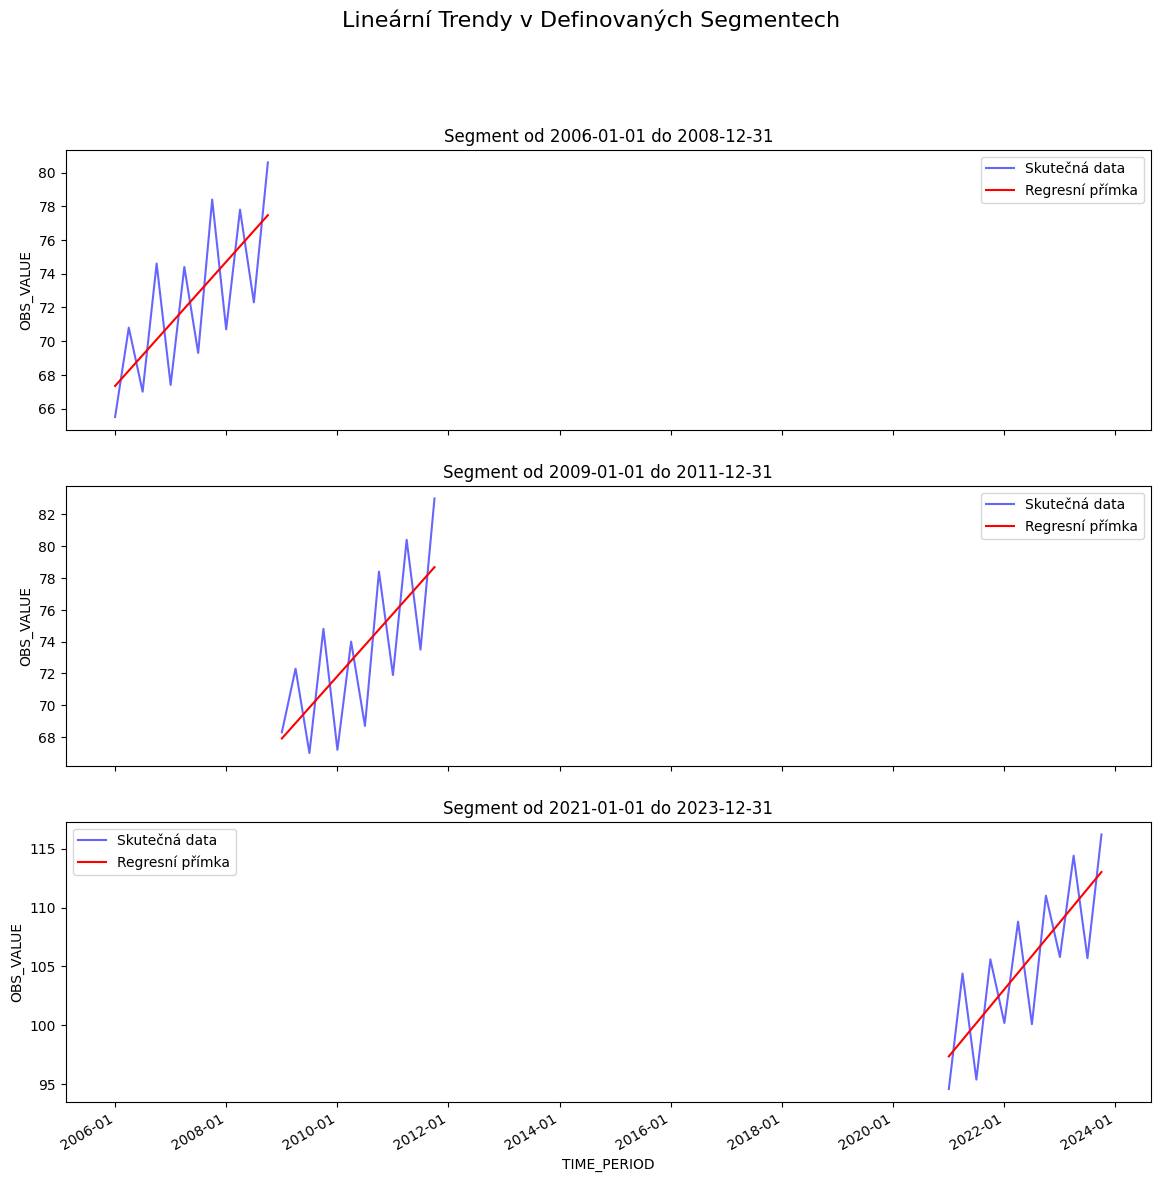

Sklon regresní přímky pro segment od 2006-01-01 do 2008-12-31: 0.010091219387122954
Sklon regresní přímky pro segment od 2009-01-01 do 2011-12-31: 0.0107349636728184
Sklon regresní přímky pro segment od 2021-01-01 do 2023-12-31: 0.015598839681416586


In [7]:
# Příprava grafu
fig, axs = plt.subplots(len(segments_definitions), 1, figsize=(14, 14), sharex=True)
fig.suptitle('Lineární Trendy v Definovaných Segmentech', fontsize=16)

# Výpis sklonů
slopes = []

for ax, (start_date, end_date) in zip(axs, segments_definitions):
    # Filtrace dat podle segmentu
    segment = filtered_data.loc[(filtered_data['TIME_PERIOD'] >= start_date) & (filtered_data['TIME_PERIOD'] <= end_date)]
    
    # Převedení na číselné hodnoty
    x_segment = np.array(segment['TIME_PERIOD'].map(pd.Timestamp.toordinal)).reshape((-1, 1))
    y_segment = np.array(segment['OBS_VALUE'])
    
    # Lineární regrese
    model_segment = LinearRegression().fit(x_segment, y_segment)
    y_pred_segment = model_segment.predict(x_segment)
    
    # Uložení sklonu
    slopes.append(model_segment.coef_[0])
    
    # Vykreslení dat a regresní přímky
    ax.plot(segment['TIME_PERIOD'], y_segment, label='Skutečná data', color='blue', alpha=0.6)
    ax.plot(segment['TIME_PERIOD'], y_pred_segment, color='red', label='Regresní přímka')
    ax.set_title(f'Segment od {start_date} do {end_date}')
    ax.set_ylabel('OBS_VALUE')
    ax.legend()

# Nastavení formátu osy x
axs[-1].set_xlabel('TIME_PERIOD')
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

# Zobrazení grafu
plt.show()

# Výpis sklonů
for (start_date, end_date), slope in zip(segments_definitions, slopes):
    print(f'Sklon regresní přímky pro segment od {start_date} do {end_date}: {slope}')

- Po proložení přímek na jednotlivé segmenty a spočítání sklonu nám vychází podobné hodnoty sklonu, dovolím si tedy tvrdit, že časová řada se po výkyvech chová podobně

# Arima (AutoRegresive Integrated Moving Average)
- Statistická metoda, která se stala velmi populární pro její efektivitu při řešení mnoha standardních jevů, které se vyskytují v datech časové řady
- Tento model  analyzuje časovou řadu na základě AutoRegresivní složky, Integrační složky a složky klouzavých průměrů.
    - AutoRegresivní složka = Zkoumá vztah mezi pozorováním a předchozím nebo zpožděném pozorováním (kolik předchozích hodnot se bere v potaz při vysvětlování současné hodnoty)
    - Integrační složka = Diference čaové řady před aplikací modelů AR a/nebo MA (kolikrát po sobě se diference aplikuje)
    - Složka klouzavých průměrů = Vyjadřuje, že část chyby časové řady se dá vysvětlit jako lineární kombinace minulých chyb (z kolika časových intervalů v minulosti se chyby v modelu uplatní)
- Následně na základě analýzy předpovídá budoucí hodnoty
- Nevýhody:
    - Není vhodný pro časové řady, které obsahují sezónní jevy
- Modely ARIMA se odhadují tzv. Box-Jenkinsovou metodou
    1) Identifikace a výběř řádu modelu (p,d,q)
        - Využívá se analýzy autokorelací a parciálních autokorelací zkoumané časové řady
    2) Odhad regresních koeficientů (obvykle metodou "maximální věrohodnosti")
    3) Testování modelu, především stacionarity jeho reziduí 
        - Stacionarita časové řady znamená očištění od trendu a sezónních jevů, které ovlivňují regresní model
- Rovnice:
    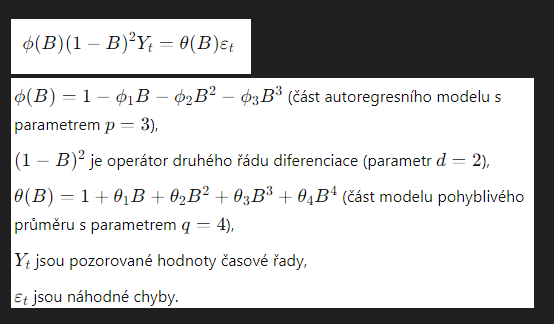

- Jaké má výstupní parametry?

### Autokorelace časové řady s různými zpožděními

- V následujícím kroku si vyhodnotíme autokorelaci časových řad pomocí autokorelačního grafu

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

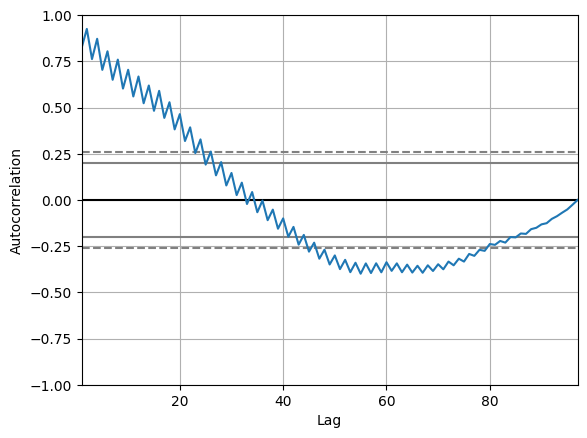

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Načtení dat
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

# Převod TIME_PERIOD z formátu 'YYYY-Qn' na 'YYYY-MM'
def convert_quarter_to_month(quarter):
    year, q = quarter.split('-Q')
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[q]
    return f'{year}-{month}'

filtered_data['TIME_PERIOD'] = filtered_data['TIME_PERIOD'].apply(convert_quarter_to_month)

# Převod na datetime
x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']


# Autokorelační graf
pd.plotting.autocorrelation_plot(y)

### Využití ARIMA modelu

### A) Nastavení optimálních parametrů a vypsání detailu modelu
- Detail modelu zobrazuje použitý model, AIC, BIC a HQIC hodnoty a mnoho dalších ukazatelů 
- Vypsané jsou také výstupní koeficienty
- Následně je provedno několik statistických testů:
    - Ljung-Box test = Kontrola, zda v časové řadě existuje autokorelace
    - Heteroskedasticita = podmíněný rozptyl náhodné veličiny není konstantní (prvky mají různou variabilitu)
    - Další...
- Další věc, kterou zobrazuji je graf reziduí a jejich husota výskytu
- Poslední je krátký souhrn základních hodnot reziduí

- Zde si znovu připravíme data německé časové řady

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Načtení dat
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

# Převod TIME_PERIOD z formátu 'YYYY-Qn' na 'YYYY-MM'
def convert_quarter_to_month(quarter):
    year, q = quarter.split('-Q')
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[q]
    return f'{year}-{month}'

filtered_data['TIME_PERIOD'] = filtered_data['TIME_PERIOD'].apply(convert_quarter_to_month)

# Převod na datetime
x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']


### b) Predikce pomocí ARIMA modelu
- Následně si vytvoříme ARIMA model na základě funkce auto_arima, který si hledá optimální parametry
- Daný model naučíme na základě tesovacích dat a vyzkoušíme predikci tesovacích datech
- Poté model vykreslíme a zhodnotíme

 ARIMA(5,2,2)(0,0,0)[0]          
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(5, 2, 2)   Log Likelihood                -117.452
Date:                Sun, 15 Sep 2024   AIC                            250.904
Time:                        23:09:32   BIC                            269.444
Sample:                             0   HQIC                           258.307
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6748      0.186      3.634      0.000       0.311       1.039
ar.L2         -0.0668      0.069     -0.965      0.334      -0.202       0.069
ar.L3         -0.1

C:\Users\tomik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


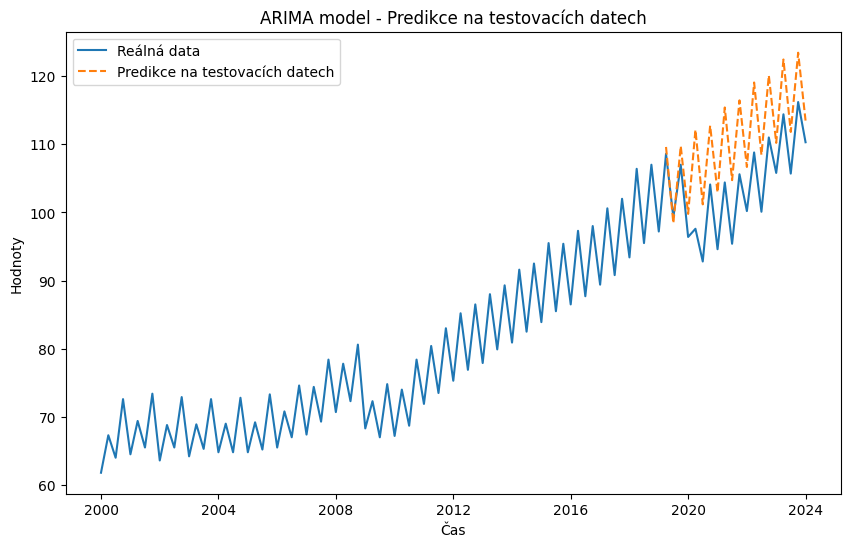

In [10]:
import matplotlib.pyplot as plt
from pmdarima import auto_arima
# Předpokládám, že máš data 'x' a 'y' - například časovou řadu 'y'
# Rozdělení na trénovací a testovací sadu (80% trénovací, 20% testovací)
train_size = int(0.8 * len(y))
y_train, y_test = y[:train_size], y[train_size:]

# Vytvoření ARIMA modelu na trénovacích datech
model = auto_arima(y_train, d=2)
print(model)

# Shrnutí modelu
print(model.summary())

# Predikce na testovací sadě
n_periods = len(y_test)
forecast = model.predict(n_periods=n_periods)

# Vytvoření časové osy pro trénovací a testovací data
x_train = x[:train_size]
x_test = x[train_size:]

# Vizualizace reálných dat a predikce
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Reálná data')  # Původní data
plt.plot(x_test, forecast, label='Predikce na testovacích datech', linestyle='--')  # Predikce
plt.xlabel('Čas')
plt.ylabel('Hodnoty')
plt.legend()
plt.title('ARIMA model - Predikce na testovacích datech')
plt.show()

- Zhodnocení modelu:
    - Model vyhodnotil jako optimální parametry kombinaci (5,2,2):
        - Při predikci hodnoty bereme v potaz 5 předchozích hodnot
            - Všechny koeficienty až na L2 jsou statisticky významné
        - Časová řada se diferencuje 2-krát než dosáhne stacionarity -> Toto se do modelu zadává manuálně, získal jsem to metodou pokus-omyl
        - Vliv minulých chyb(residuí) na sučasnou hodnotu, v tomto modelu se berou v potaz dvě zpožděné chyby při predikci
    - Rovnice modelu:
        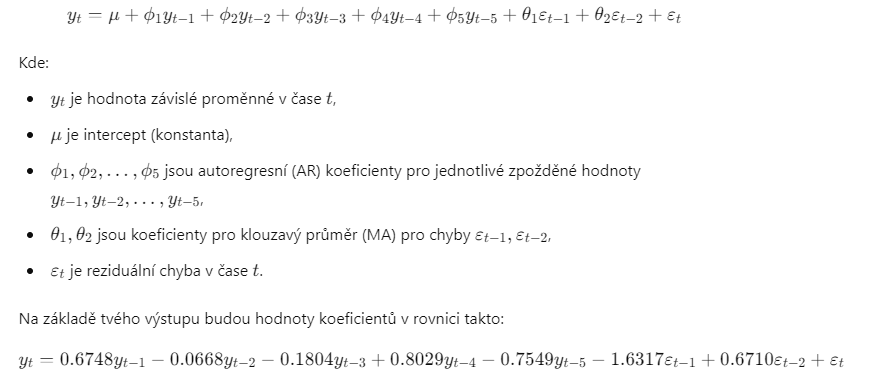
    - Hodnotící kritéria:
        - AIC -> 250
        - BIC -> 269    
        - HQIC -> 258
- Vizualizace modelu:
    - Vidíme, že predikce pokračuje ve stoupání

# Využití SARIMA modelu
## Sarima (Seasonal AutoRegressive Integrated Moving Averages)
- Model, který je velmi používaný při predikci časových řad, zachycuje krátkodobé ale i dlouhodobé závislosti mezi daty, což z něho dělá velmi robustní nástroj pro predikce
- Používá se při modelování a předpovídání časových řad se sezónní složkou
- Složky:
    - Sezónní složka -> Opakující se jevy v datech na základě nějakého určitého intervalu 
    - Autoregresivní složka -> Vztah mezi aktuální hodnotou a předchozími hodnotami
        - Zachycuje autokorelaci časové řady
    - Integrační složka -> Diferencování, které přetváří časovou řadu na stacionární časovou řadu (počet diferencí k vytvoření stacionarity)
    - Složka klouzavých průměrů -> Závislost mezi aktuální hodnotou a předchozími a předchozími předpovězenými hodnotami 
- Matematické složky:
    - Autoregresivní složka -> Vyjadřuje vztah mezi aktuální hodnotou a určitým počtem zpožděných hodnot
    - Sezónní autoregresní složka -> Vyjadřuje vztah mezi aktuální hodnotou a určitým počtem zpožděných hodnot v sezóních intervalech
    - Nesezónní diferenční složka -> Slouží ke stacionaritě časové řady
    - Sezónní diferenční složka -> Slouží ke stacionaritě časové řady na základě hodnot v sezóních intervalech
    - Složka klouzavých průměrů -> Vyjadřuje vztah mezi aktuální hodnotou a residuálními chybami z modelu klouzavých průměrů aplikovaného na opožděné pozorování
    - Sezónní složka klouzavých průměrů -> Vyjadřuje vztah mezi aktuální hodnotou a residuálními chybami z modelu klouzavých průměrů aplikovaného na opožděné pozorování v sezóních intervalech
    - Náhodná složka
- Rovnice -> 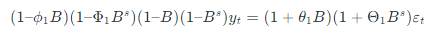
- SARIMA model je zaveden fitováním modelu historickými daty a následně je využívá pro predikci budoucích hodnot


### Důležité před nasazením SARIMA modelu
- SARIMA model předpokládá stacionaritu časové řady
    - Zda je časová řada stacionární můžeme zjistit pomocí testů:
        - ADF test
            - Pokud je p-hodnota menší než 0.05, tak časovou řadu považujeme za stacionární

### Připrava dat

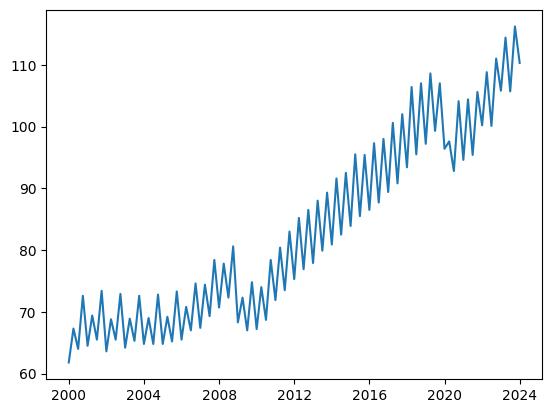

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Načtení dat
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

# Převod TIME_PERIOD z formátu 'YYYY-Qn' na 'YYYY-MM'
def convert_quarter_to_month(quarter):
    year, q = quarter.split('-Q')
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[q]
    return f'{year}-{month}'

filtered_data['TIME_PERIOD'] = filtered_data['TIME_PERIOD'].apply(convert_quarter_to_month)

# Převod na datetime
x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']

plt.plot(x, y)

In [12]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries): 
    # Perform the Dickey-Fuller test 
    result = adfuller(timeseries.dropna(), autolag='AIC')  # Odstranění NaN hodnot pro test
    p_value = result[1] 
    print(f'ADF Statistic: {result[0]}') 
    print(f'p-value: {p_value}') 
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

# Kontrola stacionarity původní a sezónně diferencované časové řady
check_stationarity(y)

y_seasonal_diff = y.diff(4).dropna()
check_stationarity(y_seasonal_diff)

ADF Statistic: 1.1844304414303375
p-value: 0.9958765271077188
Non-Stationary
ADF Statistic: -3.500482765135484
p-value: 0.007974704282929252
Stationary


- Zde provádíme několik testů na zjištění, zda je řada stacionární
- y.diff(4).dropna() -> Provádí diferenci řady pro kvartální data

### Zobrazení grafu Autokorelace a Parciální autokorelace
#### Autokorelace
- Měří vztah mezi aktuální hodnotou a předchozími hodnotami s různými zpožděními
#### Parciální autokorelace
- Představuje korelaci mezi datovým bodem a zpožděním při úpravě o vliv jiných zpoždění.

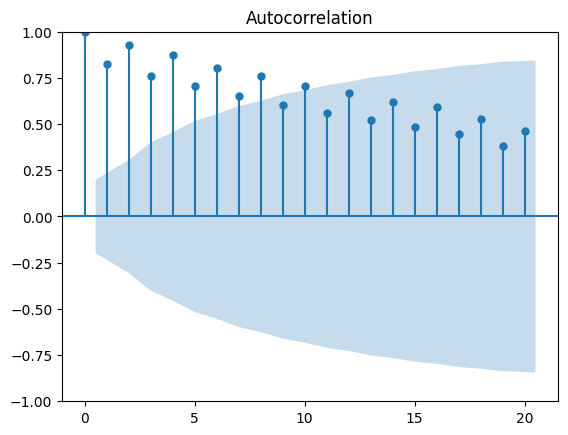

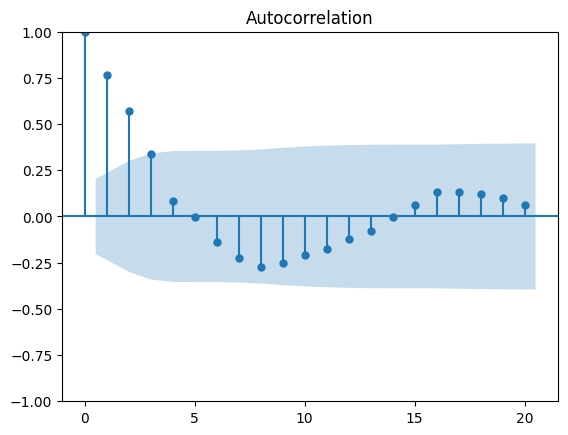

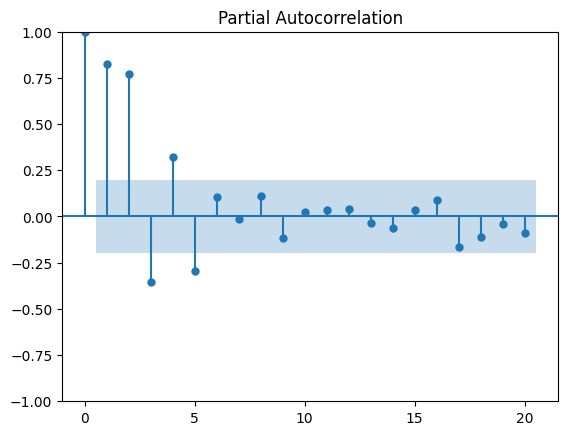

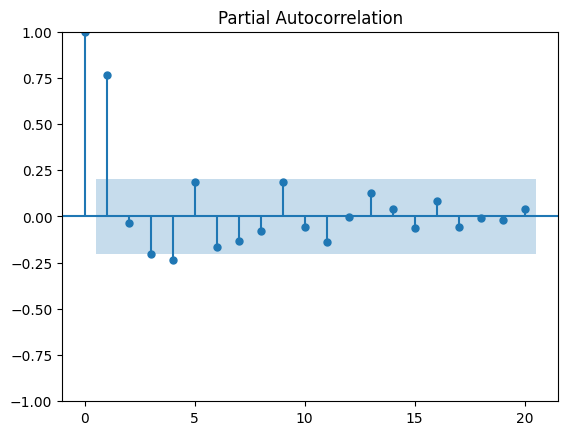

In [13]:
plot_acf(y)
plot_acf(y_seasonal_diff)
plt.show()
plot_pacf(y)
plot_pacf(y_seasonal_diff)
plt.show()


#### Pokud je korealce mimo interval spolehlivosti (zabarvená plocha), znamená to, že je korealční koeficient statistický významný a není náhodný 

### Sarima model

 ARIMA(0,1,0)(0,1,2)[4]          
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                   77
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 4)   Log Likelihood                -113.861
Date:                                Sun, 15 Sep 2024   AIC                            233.723
Time:                                        23:09:42   BIC                            240.553
Sample:                                             0   HQIC                           236.442
                                                 - 77                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.1303      0.077     -1.690     

C:\Users\tomik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


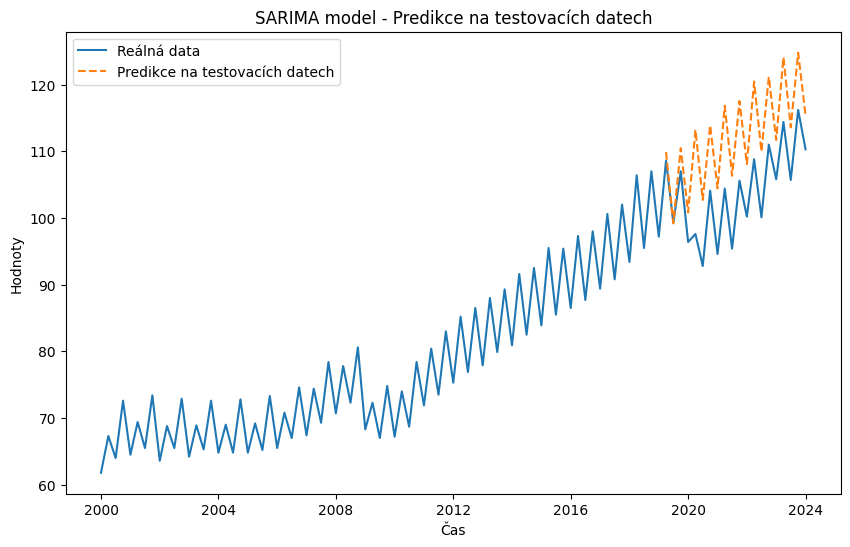

In [14]:
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Předpokládám, že máš data 'x' a 'y' - například časovou řadu 'y'
# Rozdělení na trénovací a testovací sadu (80% trénovací, 20% testovací)
train_size = int(0.8 * len(y))
y_train, y_test = y[:train_size], y[train_size:]

# Vytvoření ARIMA modelu na trénovacích datech
model = auto_arima(y_train, d=1, m=4)
print(model)

# Shrnutí modelu
print(model.summary())

# Predikce na testovací sadě
n_periods = len(y_test)
forecast = model.predict(n_periods=n_periods)

# Vytvoření časové osy pro trénovací a testovací data
x_train = x[:train_size]
x_test = x[train_size:]

# Vizualizace reálných dat a predikce
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Reálná data')  # Původní data
plt.plot(x_test, forecast, label='Predikce na testovacích datech', linestyle='--')  # Predikce
plt.xlabel('Čas')
plt.ylabel('Hodnoty')
plt.legend()
plt.title('SARIMA model - Predikce na testovacích datech')
plt.show()

- Zhodnocení modelu:
    - Model vyhodnotil jako optimální parametry kombinaci (0,1,0)(0,1,2)[4]:
        - Při predikci hodnoty bereme v potaz 0 předchozích hodnot
        - Časová řada se diferencuje 1-krát než dosáhne stacionarity -> Toto se do modelu zadává manuálně, získal jsem to metodou pokus-omyl
        - Vliv minulých chyb(residuí) na sučasnou hodnotu, v tomto modelu se berou v potaz pouze 2 sezónní zpožděné chyby při predikci
            - Ani jeden koeficient není statistický významný
    - Rovnice modelu:
        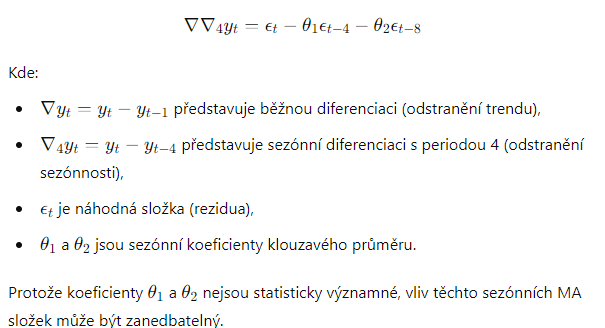
    - Hodnotící kritéria:
        - AIC -> 233
        - BIC -> 240       
        - HQIC -> 236
- Vizualizace modelu:
    - Vidíme, že predikce pokrčuje ve stoupání

# Kroskorelace mezi řadami

- Kroskorealce se používá k nalezení podobnosti mezi dvěmi časovými řadami v různých časových zpožděních
- statsmodels.tsa.stattools.ccf -> Kroskorelační funkce
    - Adjusted:
        - Pokud je adjusted=True, pak se jmenovatel upraví podle počtu pozorování na každém zpoždění, tedy jako n-k, kde n je délka časové řady a k je zpoždění (lag). To znamená, že korelace je vypočítána na základě menšího počtu pozorování, čím větší je zpoždění, protože kratší část časové řady je k dispozici pro výpočet.
- Nejlepší zpoždění vychází na lag=3

Kroskorelace CZ a DE: [ 0.95785578  0.88135368  0.90134216  0.83445408  0.85836157  0.7821012
  0.80567462  0.74354831  0.77300846  0.70210595  0.73114459  0.67239074
  0.70675641  0.64050022  0.66714167  0.60732411  0.64884528  0.57253629
  0.58966079  0.51057626  0.52631331  0.44058443  0.4491683   0.3700025
  0.38144911  0.29644938  0.30551136  0.22913398  0.24475434  0.16245011
  0.17269542  0.09825665  0.11458803  0.0365674   0.04988506 -0.02138164
 -0.00597353 -0.08833338 -0.08479303 -0.16326514 -0.1546614  -0.24140477
 -0.24157271 -0.32221841 -0.31432488 -0.40256129 -0.40824459 -0.48944679
 -0.48676807 -0.57493741 -0.57986431 -0.65860594 -0.65063384 -0.73642215
 -0.73705437 -0.80740531 -0.78593546 -0.85804208 -0.84880715 -0.91503589
 -0.88768343 -0.96794897 -0.98681965 -1.07830935 -1.08093877 -1.17649671
 -1.19637595 -1.28350614 -1.28072545 -1.36777961 -1.37489702 -1.45214244
 -1.42846704 -1.50310212 -1.50305487 -1.56514889 -1.52676806 -1.59215358
 -1.58782814 -1.63861465 -1.594

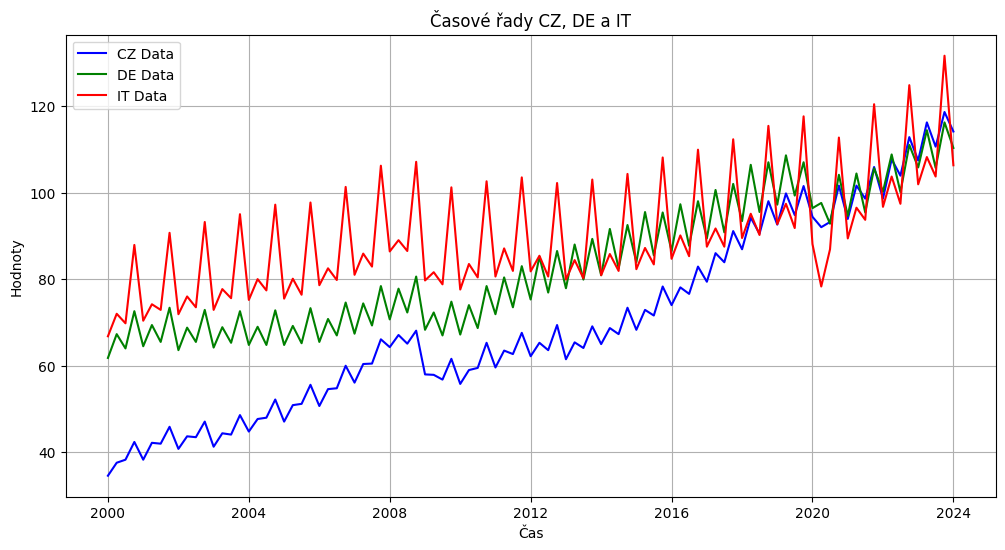

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Načtení dat
data = pd.read_csv("ei_isind_q_linear.csv")

# Filtrování dat podle několika podmínek
DE_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

IT_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'IT') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

CZ_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'CZ') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

# Konverze časové osy na datetime formát
time_index = pd.to_datetime(DE_data['TIME_PERIOD'])

# Korelace mezi třemi řadami pomocí Spearmanova koeficientu
corr_data = pd.DataFrame({
    'CZ': CZ_data['OBS_VALUE'].values,
    'DE': DE_data['OBS_VALUE'].values,
    'IT': IT_data['OBS_VALUE'].values
})

# Kroskorelace mezi CZ a DE
kroskorelace_cz_de = sm.tsa.stattools.ccf(CZ_data['OBS_VALUE'], DE_data['OBS_VALUE'], adjusted=True)
# Kroskorelace mezi DE a IT
kroskorelace_de_it = sm.tsa.stattools.ccf(DE_data['OBS_VALUE'], IT_data['OBS_VALUE'], adjusted=True)
# Kroskorelace mezi IT a CZ
kroskorelace_it_cz = sm.tsa.stattools.ccf(IT_data['OBS_VALUE'], CZ_data['OBS_VALUE'], adjusted=True)

DE_data_lagged = np.roll(DE_data['OBS_VALUE'], 2)
IT_data_lagged = np.roll(IT_data['OBS_VALUE'], 2)

corr_data_lag = pd.DataFrame({
    'CZ': CZ_data['OBS_VALUE'].values,
    'DE': DE_data_lagged,
    'IT': IT_data_lagged
})

print('Kroskorelace CZ a DE:', kroskorelace_cz_de)
print('Kroskorelace DE a IT:', kroskorelace_de_it)
print('Kroskorelace IT a CZ:', kroskorelace_it_cz)

korel_matice = corr_data.corr(method="spearman")
korel_matice_lagged = corr_data_lag.corr(method="spearman")
print(korel_matice)
print(korel_matice_lagged)

plt.figure(figsize=(12, 6))

# Vykreslení jednotlivých časových řad
plt.plot(time_index, CZ_data['OBS_VALUE'], label='CZ Data', color='blue')
plt.plot(time_index, DE_data['OBS_VALUE'], label='DE Data', color='green')
plt.plot(time_index, IT_data['OBS_VALUE'], label='IT Data', color='red')

# Přidání popisků a legendy
plt.title('Časové řady CZ, DE a IT')
plt.xlabel('Čas')
plt.ylabel('Hodnoty')
plt.legend()
plt.grid(True)
plt.show()


- Nejdříve jsem provedl kroskorelační analýzu, která mi vrátila výsledky pro jednotlivé zpoždění
    - Z těchto výsledků jsem došel k tomu, že nejlepší zpoždění pro mě bude hodnota 2
- V dalším kroku jsem udělal korelační matici pro řady bez zpoždění a poté korelační matici:
    - Česká řada bez zpoždění
    - Německá a Italská řada se zpožděním 2
- Posledním krokem této sekce bylo vykreslení všech řad, abych viděl jak řady vypadají

### Vytvoření lineárního modelu OLS
- Metoda nejmenších čtverců
    - Některé zdroje ho považují za lineární model

                            OLS Regression Results                            
Dep. Variable:                     cz   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     106.0
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           8.01e-25
Time:                        23:09:48   Log-Likelihood:                -379.55
No. Observations:                  97   AIC:                             765.1
Df Residuals:                      94   BIC:                             772.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.3891      8.597     -1.790      0.0

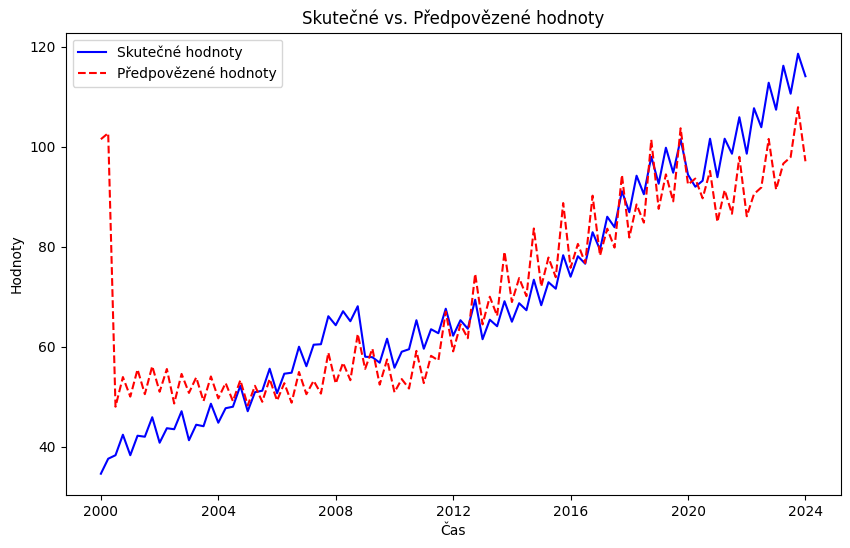

In [16]:
data = pd.DataFrame({ 
    'de': DE_data_lagged,
    'it': IT_data_lagged,
    'cz': CZ_data['OBS_VALUE'].values
})

X = data[['de', 'it']]  # Nezávislé proměnné
y = data['cz']  # Závislá proměnná

# Přidání konstanty pro odchytávání interceptu
X = sm.add_constant(X)

# Vytvoření a zfitování modelu
model = sm.OLS(y, X).fit()

# Získání koeficientů a p-hodnot
print(model.summary())

predictions = model.predict(X)

plt.figure(figsize=(10,6))
plt.plot(time_index, y, label='Skutečné hodnoty', color='blue')
plt.plot(time_index, predictions, label='Předpovězené hodnoty', color='red', linestyle='--')

plt.title('Skutečné vs. Předpovězené hodnoty')
plt.xlabel('Čas')
plt.ylabel('Hodnoty')
plt.legend()
plt.show()

- Vytovřil jsem model (OLS), který jsem nafitoval řadami DE a IT jako nezávislé proměnné a CZ jako závislou hodnotu
- Hodnocení modelu:
    - Obě nezávislé proměnné jsou statisticky významné
    - R-Squared = 0.69 -> To znamená, že model moc dobře řadu nevystihuje
    - AIC -> 765
    - BIC -> 772
    - Durbin-Watsen test = 0.3, což znamená, že se v residuích vyskytuje autokorelace
- 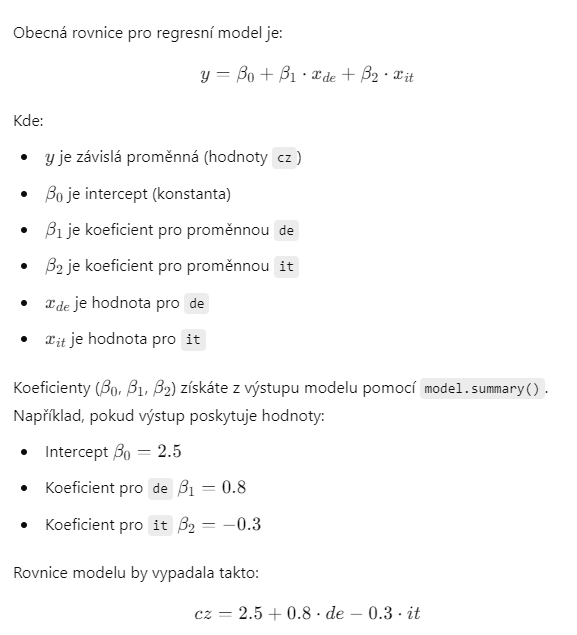

In [17]:
# Získání koeficientů
params = model.params

# Sestavení rovnice
intercept = params['const']
coef1 = params['de']
coef2 = params['it']

# Případně formátování rovnice
equation = f'y = {intercept:.2f} + ({coef1:.2f})*de + ({coef2:.2f})*it'

print('Regresní rovnice:')
print(equation)

Regresní rovnice:
y = -15.39 + (1.44)*de + (-0.38)*it


## Kontrola residuí

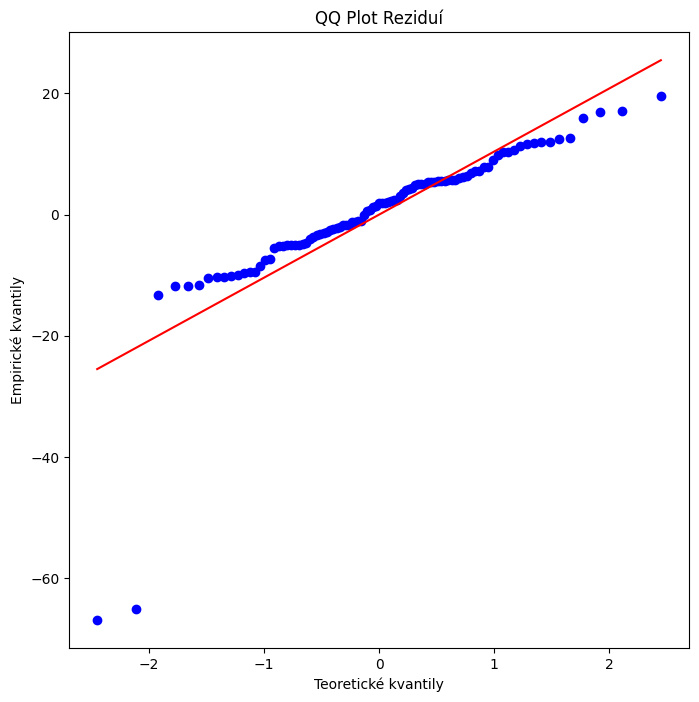

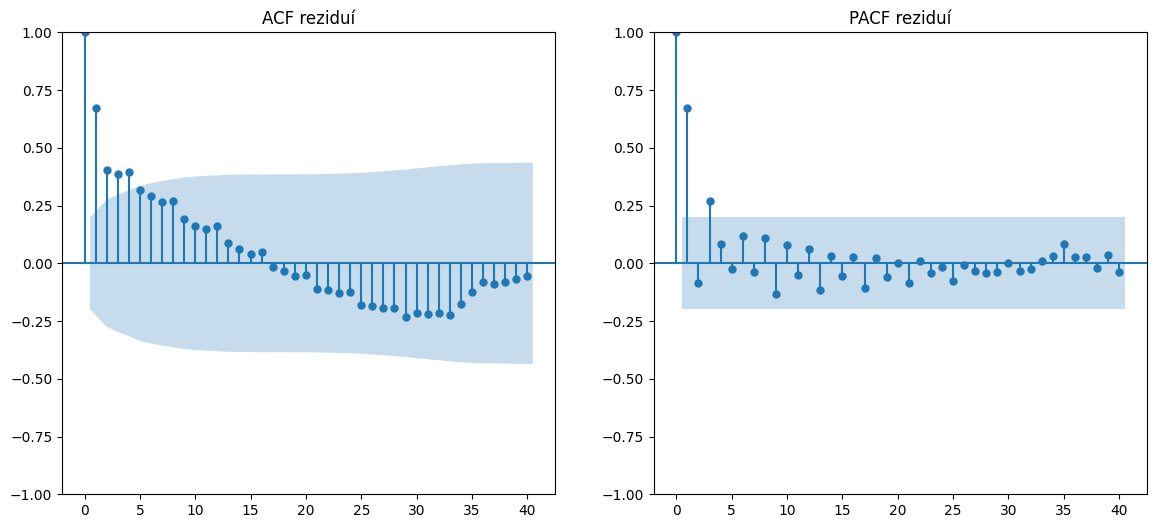

Ljung-Box test:
       lb_stat     lb_pvalue
10  134.467121  5.717247e-24


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Vypočítání reziduí
residuals = y - predictions

# Vytvoření QQ plotu
plt.figure(figsize=(8, 8))

# QQ plot
stats.probplot(residuals.dropna(), dist="norm", plot=plt)

plt.title('QQ Plot Reziduí')
plt.xlabel('Teoretické kvantily')
plt.ylabel('Empirické kvantily')


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

plot_acf(residuals.dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF reziduí')

plot_pacf(residuals.dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF reziduí')

plt.show()
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print('Ljung-Box test:')
print(lb_test)



- Nejdříve jsme udělali QQplot pro zjištění zda jsou residua normálně rozložena
- Nyní jsme vykreslili grafy pro vizualizaci Autokorelace a parciální autkorelace residuí
- Poslední krok je vyzkoušení Ljung-box testu na zjištění, zda jsou residua závislá
    - Residua nejsou nezávislá

### Využití Auto-arima s regresory

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   77
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 4)   Log Likelihood                -118.014
Date:                           Sun, 15 Sep 2024   AIC                            250.028
Time:                                   23:10:02   BIC                            265.964
Sample:                                        0   HQIC                           256.372
                                            - 77                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6488      0.196      8.397      0.000       1.264       2.034
ar.L2         -0.8304      0.185     -4.486

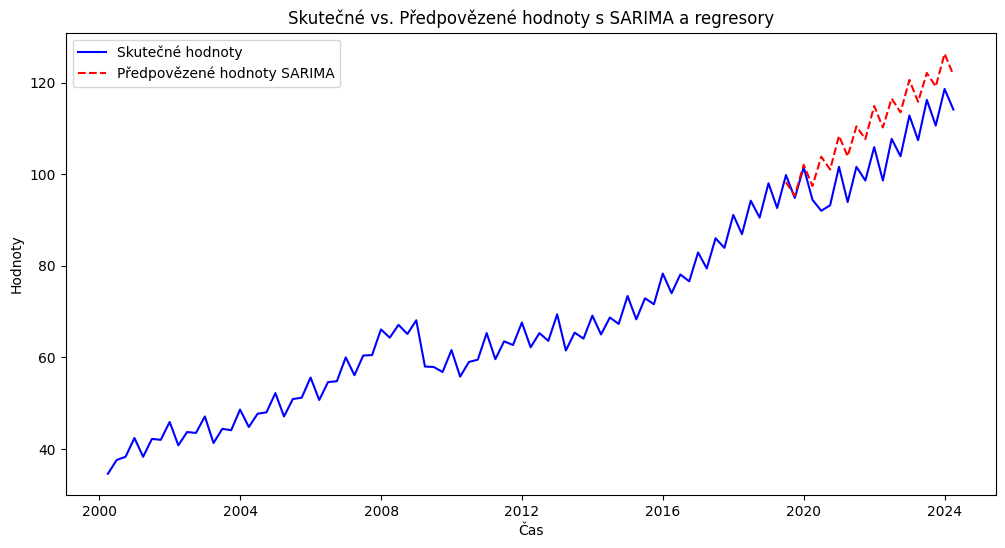

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Předpokládejme, že máte data 'DE_data_lagged', 'IT_data_lagged' a 'CZ_data'
data = pd.DataFrame({ 
    'de': DE_data_lagged,
    'it': IT_data_lagged,
    'cz': CZ_data['OBS_VALUE'].values
})

# Nezávislé proměnné
X = data[['de', 'it']]
# Závislá proměnná
y = data['cz']

# Rozdělení na trénovací a testovací data
train_size = int(0.8 * len(y))
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# Fitování ARIMA modelu s exogenními proměnnými
model = auto_arima(y_train, exogenous=X_train, seasonal=True, m=4, stepwise=True, d=1)
print(model.summary())

# Predikce na testovacích datech
forecast = model.predict(n_periods=len(y_test), exogenous=X_test)

# Vytvoření časové osy pro trénovací a testovací data
time_index = pd.date_range(start='2000-01-01', periods=len(y), freq='Q')
time_index_train = time_index[:train_size]
time_index_test = time_index[train_size:]

# Vizualizace reálných dat a predikcí
plt.figure(figsize=(12, 6))
plt.plot(time_index, y, label='Skutečné hodnoty', color='blue')
plt.plot(time_index_test, forecast, label='Předpovězené hodnoty SARIMA', color='red', linestyle='--')

plt.title('Skutečné vs. Předpovězené hodnoty s SARIMA a regresory')
plt.xlabel('Čas')
plt.ylabel('Hodnoty')
plt.legend()
plt.show()

- Poslední částí této práce je přidání regresorů z vytvořeného modelu (OLS) do auto_arima funkce
- Zvolené parametry:
    - (2, 1, 2)x(0, 1, 2, 4)
- Hodnocení modelu:
    - Všechny koeficienty jsou statisticky významné až na ma.S.L8 
    - AIC -> 250
    - BIC -> 265
    - HQIC -> 256
    - Ljung-Box -> 0.07 -> Residua jsou nezávislé
- Rovnice:
    - 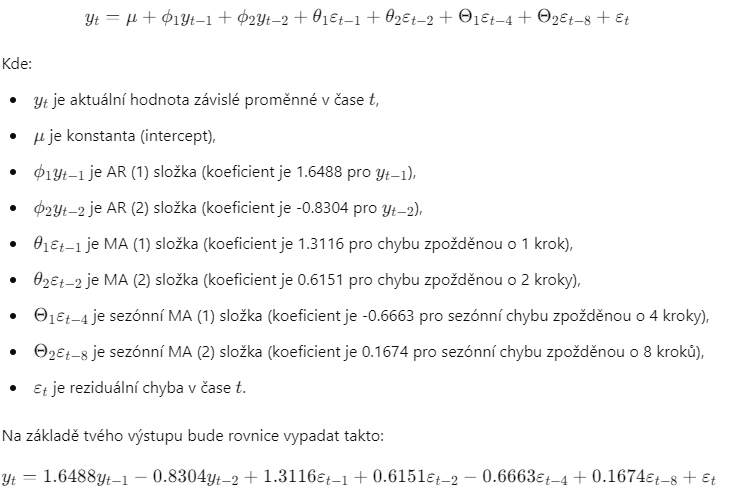

1) 3 další čas. řady
    a) kroskorelace mezi řadami -> mám
        - Odhadnout z toho zpoždění -> mám
        - Lineární model mezi všemi řadami, najít koeficienty a spočítat p-hodnoty -> mám
        - Vyřazovat řady podle p-hodnot > 0.05
            - Kroková regrese
            - Manuální -> mám
        - Zohlednit zpoždění -> mám
        - Vybrat správný lag a tím udělat optimální model -> mám (Ačkoliv model nic moc)
    b) Kontrola residuí modelu
        - Ljoung-box test -> mám, rezidua nejsou náhodná a existuje autokorelace
        - Autokorelační funkce -> mám
        - Dát to autoarimy s regresory z bodu A -> mám
    c) Podívat se na modely, které jsem stvořil 
        - ARIMA
        - SARIMA
        - Optimální model z posledního úkolu